In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import numpy as np
import torch.nn as nn
import string
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import torch.nn.functional as F
from sklearn.metrics import classification_report

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

VECTOR_PATH = 'glove.6B/glove.6B.50d.txt'
EMB_DIMENSION = 50
MAX_SEQ_LENGTH = 96 

### Dataset Class

In [3]:
class EntityDataset(Dataset):

    def __init__(self, data_dir):
        """Initialize the attributes of the object of the class."""
        
        # data directory
        self.data_dir = data_dir
        
        # load text dataset  
        self.sentences = self._read_data(data_dir, 'sentences')

        # load text dataset  
        self.labels = self._read_data(data_dir, 'labels')  
        
        # load the glove embedding
        self.vector_path = VECTOR_PATH
        
        # set the embedding dimension 50/100/300
        self.emb_dimension = EMB_DIMENSION
        
        
        # set the maximum sequence length or max tweet length
        self.max_seq_len = MAX_SEQ_LENGTH
        
        # create the vocabulary from the dataset
        self.vocab = sorted(self._create_vocabulary())
        
        
        # map word or tokens to index 
        self.word_to_index = {word: idx+1 for idx, word in enumerate(sorted(self.vocab))}
        
        # set pad token index to 0 and unk token index last of vocab
        self.word_to_index['[PAD]'] = 0
        self.word_to_index['[UNK]'] = len(self.vocab)+1
        
        # define the entitly labels to index values
        self.label_to_index = {'B':0, 'I':1, 'O':2, '[PAD]':-1} 

        
        # create the embedding vector
        self.word_embeddings = self._create_embedding()
        
       
        

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.sentences)

    def __getitem__(self, index):
        """Return a data sample for a given index, along with the lable of the corresponding tweet"""
        
        
        # - get the data sample corresponding to 'index' (use the list 'self.image_path_list')
        data_sample = self.sentences[index]
        label = self.labels[index]
        
        # tokenize the sentence and label
        tokens = self._tokenize_text(data_sample)
        labels = self._tokenize_text(label)

        # use the word_to_index mapping to transform the tokens into indices and save them into an IntTensor
        x = torch.IntTensor([self.word_to_index[word] 
                             if word in self.word_to_index 
                             else self.word_to_index["[UNK]"] 
                             for word in tokens])
        
        # transform the variable to cuda or cpu
        x = x.to(device)
        
        
        
        
        # get the index-th label and store it into a FloatTensor
        y = [self._label_map(l) for l in labels]
        y = torch.IntTensor(torch.stack(y))
        # transform the variable to cuda or cpu
        y = y.to(device)
        # stores the text indices and the label into a dictionary
        features = {'token_ids': x, 'labels': y}
        
        
        return features

    
    def _create_embedding(self):
        
        """create a matrix containing word vectors"""

        # load the glove embedding to a dict. token is the key and value is the vector
        embeddings_index = {}
        with open(self.vector_path,'r') as file:
            embeddings_index = {line.split()[0]: np.asarray(line.split()[1], dtype='float32') for line in file}

        # create the embedding matrix. keep the words that only present in the dataset. 
        # each row represent one vector
        # row index is the word map index
        embedding_matrix = np.zeros((len(self.word_to_index) + 2, self.emb_dimension))
        for word, i in self.word_to_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        
        embedding_matrix[len(self.vocab)+1] = torch.randn(self.emb_dimension)
                
        return torch.tensor(embedding_matrix, device=device)
        
        
    def _create_vocabulary(self):
        """Create a vocabulary of unique words from the given text files."""
        
        path = 'vocab.txt'
        with open(path, 'r') as file:
            vocab = [line.strip() for line in file]

        return list(vocab)

    def _tokenize_text(self, line):
        """
        Remove non-characters from the text and pads the text to max_seq_len.
        *!* Padding is necessary for ensuring that all text_files have the same size
        *!* This is required since DataLoader cannot handle tensors of variable length

        Return a list of all tokens in the text
        """

        tokens = line.split()
        for i in range(self.max_seq_len - len(tokens)):
            tokens.append('[PAD]')
        return tokens
    
    def _label_map(self,label,class_num=3):
        
        """ convert to labels to one hot vectors"""
        
        one_hot = torch.zeros(class_num, dtype=torch.int32)
        idx = self.label_to_index[label.upper()]
        if idx!=-1:
            one_hot[idx] = 1
        
        return one_hot
            
            
    
    def _read_data(self, path, pattern):
        
        """ read txt file and return as list of strings"""
        
        path = f'{path}/{pattern}.txt'
        with open(path, 'r') as file:
            data = [line.strip() for line in file]

        
        return data
         

### Create Dataloaders

In [4]:
dataset_train = EntityDataset('Dataset/train')
dataset_test = EntityDataset('Dataset/test')
dataset_dev = EntityDataset('Dataset/dev')

In [5]:
VOCAB = dataset_train.vocab


In [6]:
batch_size = 8
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=True)

In [7]:
# print an example batch

batch_example = next(iter(train_dataloader))
tweet_batch_example = batch_example['token_ids']
labels_batch_example = batch_example['labels']

print(tweet_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 96])
torch.Size([8, 96, 3])


### Create RNN model class

In [8]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, word_embeddings,
                 max_sequence_length, num_layers, hidden_size, bidirectional, output_size, act_fn):
        super(RNN, self).__init__()
        
        # embedding layer: converts tokens ids with respectve word vec
        self.input_layer = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.input_layer.weight.data = word_embeddings
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size = hidden_size, 
                           num_layers = num_layers, 
                           bidirectional=bidirectional, batch_first=True)
        
        if bidirectional:
            self.direction = 2
        else:
            self.direction = 1
            
        self.layers = num_layers
        
        
            
        self.hidden_size = hidden_size

        # output layer
        self.output_layer = nn.Sequential(
            nn.Linear(self.direction*hidden_size, output_size),act_fn)
    
    def forward(self, x):
        
        # get embedding 
        emb = self.input_layer(x)
        
        batch = x.shape[0]
        # initialize a hidden state and cell state
        h0,c0 = self.init_hidden(batch)
        
        # get output from lstm layers
        l,_ = self.lstm(emb.float(),(h0,c0))
        
        # flatten the output
        l = l.reshape(-1,l.shape[2])
    
        # get final class probabilities
        out = self.output_layer(l)
        
        return out
    
    def init_hidden(self, batch_size):
                
        torch.manual_seed(0)
        h0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=device) 
        c0 = torch.randn(self.direction*self.layers, batch_size, self.hidden_size, device=device)

        return h0,c0

### Training and Evaluation Functions

In [16]:
def index_to_tag(labels):
    
    """convert a batch of label indices to list of tags"""
    
    #define index to tag mapping
    indexMap = {0:'B', 1:'I', 2:'O'}
    
    #reshape labels to batch_size*MAX_SEQ_LENGTH
    labels = labels.reshape((-1,MAX_SEQ_LENGTH))
    
    batchTags = []
    
    #convert label index to tags
    for batch in labels:
    
        tags = [indexMap[idx.item()] for idx in batch]
        
        batchTags.append(tags)
    
    return batchTags

def index_to_token(token_ids):
    
    """convert a batch of token indices to list of strings"""
    
    batchSent = []
    
    for item in token_ids:
    
        sent = [VOCAB[idx-1] if idx < len(VOCAB) else 'UNK' for idx in item if idx!=0]
        
        batchSent.append(sent)
    
    return batchSent


def print_predictions(tokens, pred_tags, true_tags):
    
    
    batch_tokens = index_to_token(tokens)
      
    batch_pred_tags = index_to_tag(pred_tags)
    
    batch_true_tags = index_to_tag(true_tags)
    
    
    

    
    from colorama import Fore, Style, Back
    
    outputs = []
    
    preds = []
    
    true = []
    
    for tokens,true_tags,pred_tags in zip(batch_tokens,batch_pred_tags,batch_true_tags):
        
        true_tags = true_tags[:len(tokens)]
        pred_tags = pred_tags[:len(tokens)]
        
        output = []
    
        for t,tl,pl in zip(tokens,true_tags,pred_tags):

            assert len(tokens) == len(pred_tags) == len(true_tags)

            if tl == pl:
                o = f"{t} {Back.GREEN}[{tl}][{pl}]{Style.RESET_ALL}"

            else:
                o = f"{t} {Back.GREEN}[{tl}]{Style.RESET_ALL}{Back.RED}[{pl}]{Style.RESET_ALL}"


            output.append(o)
            
        outputs.append(" ".join(output))
        preds.extend(pred_tags)
        true.extend(true_tags)
    
    return outputs, preds, true



def eval_lstm(model, eval_dataloader, return_predictions = False):
    
    model = copy.deepcopy(model)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 
    
    predictions = []

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for batch in eval_dataloader:

            #get sentences and labels
            sent = batch['token_ids']
            labels = batch['labels']
            
            
            #get number of class or tags
            num_class = labels.shape[-1]
    
            #find the padded tokens
            padx = (sent > 0).float()
            
            #reshape it to make it as the same shape with labels
            padx = padx.reshape(-1)
            
            batch_size = sent.shape[0]
            
            
            #count non-pad tokens
            num_tokens = padx.sum().item()
        
            #count padded tokens
            num_pad_tokens = padx.shape[0] - num_tokens
            
            #reshape it to make it as the same shape with model output
            labels = labels.reshape(-1,num_class)
            
            # Get the predicted labels
            y_predicted = model(sent)
            
            # To get the predicted labels, we need to get the max over all possible classes
            # multiply with padx to ignore padded token predictions 
            label_predicted = torch.argmax(y_predicted.data, 1)*padx
            labels = torch.argmax(labels, 1)*padx
            

            # Compute accuracy: count the total number of samples,
            #and the correct labels (compare the true and predicted labels)
            
            total_labels += num_tokens #only added the non-padded tokens in count
            
            # subtract the padded tokens to ignore padded token predictions in final count
            correct_labels += ((label_predicted == labels).sum().item() - num_pad_tokens)
            
            # get output
            if return_predictions:
                predictions.append(print_predictions(sent,label_predicted,labels))
    
    accuracy = 100 * correct_labels / total_labels
    
    if return_predictions:
        return accuracy, predictions
    
    return accuracy

In [10]:
def loss_fn(outputs, labels):
    
    #define cross entropy loss 
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    #reshape labels to give a flat vector of length batch_size*seq_len
    num_class = labels.shape[-1]
    
    # reshape label to make it similar to model output
    labels = labels.reshape(-1,num_class) 

    #get loss
    loss = criterion(outputs, labels.float())
    
    #get non-pad index
    non_pad_index=[i for i in range(labels.shape[0]) if labels[i].sum()!=0]
    
    #get final loss
    loss = loss[non_pad_index].mean()
    
    return loss
    
#     #reshape labels to give a flat vector of length batch_size*seq_len
#     num_class = labels.shape[-1]
    
#     # reshape label to make it similar to model output
#     labels = labels.reshape(-1,num_class) 
    

#     #the number of non-paded tokens. since padded tokens are labeled as [0,0,0], it doesn't effect count
#     num_tokens = int(torch.sum(labels))
    

#     #pick the values corresponding to labels and multiply by mask
#     outputs = outputs*labels

#     #cross entropy loss for all non 'PAD' tokens
#     return -torch.sum(outputs)/num_tokens
      
    

def training_lstm(model, train_dataloader, valid_dataloader, num_epochs, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists to record the training loss over epochs
    loss_all_epochs = []
    val_loss_all_epochs = []
    
    best_accuracy = 0.0
    
    
    accuracy = []
    
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        val_loss_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, batch in enumerate(train_dataloader):
            
            label = batch['labels']

            optimizer.zero_grad()
            
            out = model_tr.forward(batch['token_ids'])
            l = loss_fn(out,label)
            l.backward()
            optimizer.step()
            loss_current_epoch += (l.item())
            
            val_loss_epoch += loss_fn(out,label).item()
            
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch


        # At the end of each epoch, record and display the loss over all batches in train and val set
        loss_current_epoch = loss_current_epoch/len(train_dataloader)
        val_loss_epoch = val_loss_epoch/len(train_dataloader)
        
        loss_all_epochs.append(loss_current_epoch)
        val_loss_all_epochs.append(val_loss_epoch)
        
        # 
        acc = eval_lstm(model_tr, valid_dataloader)
        
        accuracy.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            torch.save(model_tr.state_dict(), 'model_opt.pt')
            
        
        
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs ,accuracy


### Training

In [11]:
#the vocab size that is built from train set
vocab_size = len(dataset_train.vocab)
# the embedding dimenstion 50/100/300
emb_dim = EMB_DIMENSION
# get the embedding matrix
word_embeddings = dataset_train.word_embeddings
# max sequence length
max_sequence_length = MAX_SEQ_LENGTH

#define lstm layers
num_layers = 5
#define hidden size
hidden_size = 32
#set if LSTM should be bidirectional 
bidirectional = False
# output size i.e class size 
output_size = 3
# activation function
act_fn = nn.LogSoftmax(dim=1)

# create a RNN  model instance. REMARK: remove .cuda() at the end if gpu is not available
rnn = RNN(vocab_size, emb_dim, word_embeddings, max_sequence_length, 
          num_layers,hidden_size, bidirectional, output_size, act_fn).cuda()


### Trial & Error

In [12]:

# o = rnn.forward(tweet_batch_example)
# o.shape
# loss_fn(o,labels_batch_example)

# l =labels_batch_example.reshape(-1,3)
# non_pad_index=[i for i in range(l.shape[0]) if l[i].sum()!=0 ]
# l = l[non_pad_index]
# l.shape


# l = labels_batch_example.reshape(-1,3)
# l= torch.argmax(l,1)
# out = print_predictions(tweet_batch_example,l,l)
# print(out[0])

In [13]:

# number of epochs
num_epochs = 75
# learning rate
learning_rate = 0.01

# train model
model_tr, loss_all_epochs, accuracy = training_lstm(rnn, train_dataloader, valid_dataloader, num_epochs, learning_rate)


/home/hossain/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/75], Loss: 0.7829
Epoch [2/75], Loss: 0.6181
Epoch [3/75], Loss: 0.4255
Epoch [4/75], Loss: 0.3256
Epoch [5/75], Loss: 0.2747
Epoch [6/75], Loss: 0.2533
Epoch [7/75], Loss: 0.2296
Epoch [8/75], Loss: 0.2188
Epoch [9/75], Loss: 0.2168
Epoch [10/75], Loss: 0.2003
Epoch [11/75], Loss: 0.1931
Epoch [12/75], Loss: 0.1746
Epoch [13/75], Loss: 0.1572
Epoch [14/75], Loss: 0.1397
Epoch [15/75], Loss: 0.1291
Epoch [16/75], Loss: 0.1288
Epoch [17/75], Loss: 0.1182
Epoch [18/75], Loss: 0.1116
Epoch [19/75], Loss: 0.1030
Epoch [20/75], Loss: 0.0955
Epoch [21/75], Loss: 0.0880
Epoch [22/75], Loss: 0.0874
Epoch [23/75], Loss: 0.0866
Epoch [24/75], Loss: 0.0797
Epoch [25/75], Loss: 0.0756
Epoch [26/75], Loss: 0.0781
Epoch [27/75], Loss: 0.0707
Epoch [28/75], Loss: 0.0702
Epoch [29/75], Loss: 0.0682
Epoch [30/75], Loss: 0.0594
Epoch [31/75], Loss: 0.0508
Epoch [32/75], Loss: 0.0466
Epoch [33/75], Loss: 0.0500
Epoch [34/75], Loss: 0.0458
Epoch [35/75], Loss: 0.0421
Epoch [36/75], Loss: 0.0436
E

# Visualization

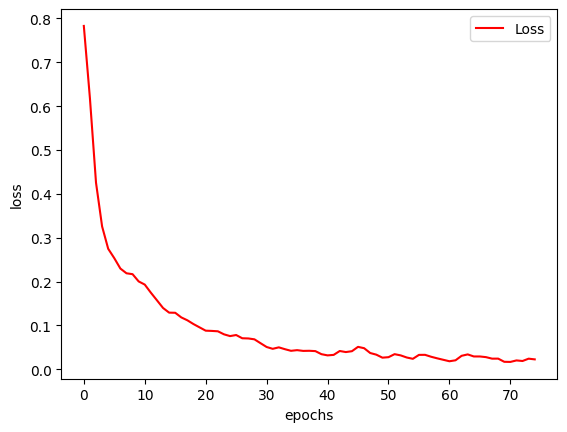

In [14]:
plt.figure()
epochs = [i for i in range(num_epochs)]
plt.plot(epochs, loss_all_epochs, 'r', label='Loss')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend()
plt.show()

### Eval Test set 

In [17]:
acc, preds = eval_lstm(model_tr,test_dataloader,True)
outputs=[]
pred_labels=[]
true_labels = []
for o,p,t in preds:
    outputs.extend(o)
    pred_labels.extend(p)
    true_labels.extend(t)


In [18]:
print(classification_report(pred_labels,true_labels))

              precision    recall  f1-score   support

           B       0.54      0.50      0.52       328
           I       0.67      0.55      0.61       339
           O       0.87      0.91      0.89      1801

    accuracy                           0.81      2468
   macro avg       0.69      0.66      0.67      2468
weighted avg       0.80      0.81      0.80      2468



In [23]:
for i, out in enumerate(outputs[:3]):
    print(out)
    print('\n')

The [O][O] goals [O][O] of [O][O] this [O][O] work [O][O] is [O][O] UNK [O][O] UNK [O][O] to [O][O] UNK [O][O] the [O][O] most [O][O] relevant [O][O] features [O][O] for [O][O] this [O][O] UNK [O][B] distinction [O][I] and [O][O] second [O][O] to [O][O] build [O][O] an [O][O] automatic [B][B] UNK [O][I] system [O][I] of [O][O] UNK [O][B] UNK [O][I] according [O][O] to [O][O] their [O][O] UNK [B][B]


The [O][O] approach [O][O] obtained [O][O] state [B][B] of [I][I] the [I][I] art [O][I] results [O][O] by [O][O] combining [O][O] several [O][O] string [B][B] kernels [I][I] using [O][O] multiple [B][B] UNK [I][I] learning [I][I]


UNK [O][O] the [O][O] presentation [O][O] UNK [O][O] examples [O][O] are [O][O] used [O][O] for [O][O] UNK [O][O]


